In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/dataset/MVSA-multiple.zip'
extract_path = '/content/dataset'

# Create the extraction directory
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extraction
os.listdir(extract_path)

['MVSA']

In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, LSTM, Embedding, Input, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * p * r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)



In [ ]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
from tensorflow.keras import layers, Model
from keras_tuner.tuners import RandomSearch
import tensorflow as tf
import os

# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]  # Lemmatize and remove stop words
    return ' '.join(tokens)

# Paths
label_results_path = os.path.join(extract_path, 'MVSA/labelResultAll.txt')
data_folder_path = os.path.join(extract_path, 'MVSA/data')

# Load the label results file
label_results = pd.read_csv(label_results_path, delimiter='\t', header=None, names=['ID', 'annotation1', 'annotation2', 'annotation3'])

# Split and process the text, image columns
def safe_split(annotation):
    parts = annotation.split(',')
    if len(parts) != 2:
        return ['unknown', 'unknown']
    return parts

for i in range(3):
    label_results[[f'text_sentiment_{i+1}', f'image_sentiment_{i+1}']] = label_results[f'annotation{i+1}'].apply(safe_split).apply(pd.Series)

label_results.drop(columns=[f'annotation{i+1}' for i in range(3)], inplace=True)

def get_majority_sentiment(row):
    text_sentiments = row[[f'text_sentiment_{i+1}' for i in range(3)]]
    image_sentiments = row[[f'image_sentiment_{i+1}' for i in range(3)]]
    majority_text_sentiment = Counter(text_sentiments).most_common(1)
    majority_image_sentiment = Counter(image_sentiments).most_common(1)
    text_sentiment = majority_text_sentiment[0][0] if len(majority_text_sentiment) == 1 and majority_text_sentiment[0][1] > 1 else 'unknown'
    image_sentiment = majority_image_sentiment[0][0] if len(majority_image_sentiment) == 1 and majority_image_sentiment[0][1] > 1 else 'unknown'
    return pd.Series([text_sentiment, image_sentiment], index=['text_sentiment', 'image_sentiment'])

label_results[['text_sentiment', 'image_sentiment']] = label_results.apply(get_majority_sentiment, axis=1)
label_results = label_results[(label_results['text_sentiment'] != 'unknown') & (label_results['image_sentiment'] != 'unknown')]

# Load the image-text data
files = os.listdir(data_folder_path)
image_files = [f for f in files if f.endswith('.jpg')]
text_files = [f for f in files if f.endswith('.txt')]

# Create a DataFrame to hold the information
data = {'ID': [], 'image_path': [], 'text': []}

def read_text_file(file_path):
    encodings = ['utf-8', 'latin-1', 'ISO-8859-1']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()
        except UnicodeDecodeError:
            continue
    return None

for image_file in image_files:
    file_id = os.path.splitext(image_file)[0]
    text_file = file_id + '.txt'
    if text_file in text_files:
        text_content = read_text_file(os.path.join(data_folder_path, text_file))
        if text_content:
            data['ID'].append(file_id)
            data['image_path'].append(os.path.join(data_folder_path, image_file))
            data['text'].append(text_content)

df = pd.DataFrame(data)
df['ID'] = df['ID'].astype(str)
label_results['ID'] = label_results['ID'].astype(str)
df = pd.merge(df, label_results[['ID', 'text_sentiment', 'image_sentiment']], on='ID')

# Filter to keep only rows where text sentiment and image sentiment are the same
df = df[df['text_sentiment'] == df['image_sentiment']]

# Apply text preprocessing
df['processed_text'] = df['text'].apply(preprocess_text)
# Display the first few rows of the DataFrame
print(df.head())
# Find the size of the DataFrame
dataframe_size = df.shape
print(f"The DataFrame has {dataframe_size[0]} rows and {dataframe_size[1]} columns.")

# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['processed_text'].values)
sequences = tokenizer.texts_to_sequences(df['processed_text'].values)

# Define maximum length based on 95% coverage
df['text_length'] = df['processed_text'].apply(lambda x: len(x.split()))
max_length_coverage = df['text_length'].quantile(0.95)
max_length = int(max_length_coverage)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Encode the sentiment labels for text data
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['text_sentiment_encoded'] = df['text_sentiment'].map(sentiment_mapping)
y_text = tf.keras.utils.to_categorical(df['text_sentiment_encoded'], num_classes=3)

# Train-test split
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(padded_sequences, y_text, test_size=0.2, random_state=42, stratify=y_text)

# Adjust class weights
class_weights_dict = {
    0: 1.0 * 4.0,  # Increase weight for Negative class, moderate increase
    1: 0.98 * 1.5, # Moderate increase for Neutral class
    2: 1.0         # Keep Positive class weight as is
}


# Hyperparameter Tuning Model Definition
def build_text_model(hp):
    text_input = layers.Input(shape=(X_train_text.shape[1],))
    x = layers.Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', min_value=64, max_value=256, step=32))(text_input)
    num_layers = hp.Int('num_layers', 1, 3)
    for i in range(num_layers):
        x = layers.Bidirectional(layers.LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                                             return_sequences=(i < num_layers - 1),
                                             kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=[1e-4, 1e-3]))))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=[1e-4, 1e-3])))(x)
    x = layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = RandomSearch(
    build_text_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/sentiment_analysis_model17/',
    project_name='text_model_tuning'
)

# Run the hyperparameter search with class weights
tuner.search(X_train_text, y_train_text, epochs=50, validation_split=0.2, class_weight=class_weights_dict, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Get the best hyperparameters and train the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
text_model = tuner.hypermodel.build(best_hps)
history = text_model.fit(X_train_text, y_train_text, epochs=50, batch_size=32, validation_split=0.2, class_weight=class_weights_dict, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Save the best text model
text_model_save_path = '/content/drive/MyDrive/sentiment_analysis_model17/best_text_model1.keras'
text_model.save(text_model_save_path)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


      ID                            image_path  \
0  21132  /content/dataset/MVSA/data/21132.jpg   
1  12816  /content/dataset/MVSA/data/12816.jpg   
4  15546  /content/dataset/MVSA/data/15546.jpg   
5  15483  /content/dataset/MVSA/data/15483.jpg   
6  11540  /content/dataset/MVSA/data/11540.jpg   

                                                text text_sentiment  \
0                                     Old red rabbit        neutral   
1  An aster covered in morning dew and cobwebs. M...       positive   
4  Crafted in cotton fleece, this tunic will brin...       positive   
5  Keeping refreshed @ Trinity Bellwoods Flea unt...        neutral   
6  How well does the city do in preserving histor...        neutral   

  image_sentiment                                     processed_text  
0         neutral                                     old red rabbit  
1        positive  aster covered morning dew cobweb mcmaster fore...  
4        positive  crafted cotton fleece tunic bring fall h

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
print(f"Best embedding dimension: {best_hps.get('embedding_dim')}")
print(f"Number of LSTM layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"LSTM units in layer {i+1}: {best_hps.get(f'lstm_units_{i}')}")
print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Dense layer units: {best_hps.get('dense_units')}")
print(f"L2 regularization: {best_hps.get('l2_reg')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")


Best embedding dimension: 96
Number of LSTM layers: 2
LSTM units in layer 1: 128
LSTM units in layer 2: 128
Dropout rate: 0.4
Dense layer units: 64
L2 regularization: 0.0001
Learning rate: 0.001


In [ ]:
# Evaluate the text model
val_loss, val_accuracy = text_model.evaluate(X_val_text, y_val_text)

# Print the validation accuracy and loss
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate classification report and confusion matrix for the text model
from sklearn.metrics import classification_report, confusion_matrix

# Predict the classes
y_pred = text_model.predict(X_val_text)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoding to class labels
y_true = np.argmax(y_val_text, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6223 - loss: 1.2215
Validation Loss: 1.3076
Validation Accuracy: 0.5988
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.40      0.27       121
           1       0.49      0.51      0.50       882
           2       0.74      0.67      0.70      1517

    accuracy                           0.60      2520
   macro avg       0.48      0.52      0.49      2520
weighted avg       0.63      0.60      0.61      2520

Confusion Matrix:
 [[  48   53   20]
 [ 100  450  332]
 [  93  413 1011]]


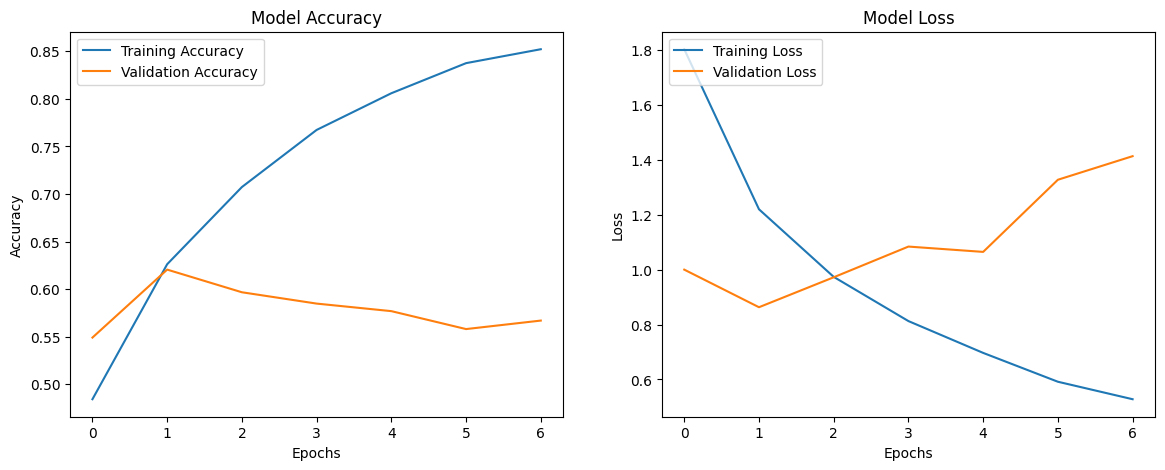

In [ ]:
import matplotlib.pyplot as plt

def plot_training_validation_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Call the function to plot the metrics
plot_training_validation_metrics(history)
